In [64]:
import torch
import torch.nn as nn
from torch import Tensor
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import v2
from tqdm import tqdm

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

In [55]:
class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transforms=None) -> None:
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transforms = transforms
        self.images = os.listdir(image_dir)

    
    def __len__(self):
        return len(self.images)
    

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transforms:
            image = self.transforms(image)
            mask = self.transforms(mask)

        return image, mask

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, padding=1) -> None:
        super(DoubleConv, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,    
                        out_channels=out_channels,
                        kernel_size=3,
                        stride=1,
                        padding=padding,
                        bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=padding,
                      bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True)
        )

    
    def forward(self, x: Tensor) -> Tensor:
        out = self.conv(x)
        return out

In [7]:
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features = [64, 128, 256, 512]) -> None:
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down sampling
        for feature in features:
            self.downs.append(DoubleConv(in_channels=in_channels,
                                         out_channels=feature))
            in_channels = feature

        # Up sampling
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(in_channels=feature*2,
                                   out_channels=feature,
                                   kernel_size=2,
                                   stride=2)
            )
            self.ups.append(
                DoubleConv(
                    in_channels=feature*2,
                    out_channels=feature
                )
            )

        self.bottleneck = DoubleConv(
            in_channels=features[-1],
            out_channels=features[-1] * 2
        )

        self.final_conv = nn.Conv2d(
            in_channels=features[0],
            out_channels=out_channels,
            kernel_size=1,
            padding=0
        )

    
    def forward(self, x: Tensor):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)

        skip_connections.reverse()
        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip_connection = skip_connections[i // 2]
            
            # print(x.shape, skip_connection.shape)

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            # print(x.shape, skip_connection.shape)

            x = torch.cat((x, skip_connection), dim=1)
            x = self.ups[i + 1](x)

        x = self.final_conv(x)

        return x

In [8]:
model = UNET().to(DEVICE)

inp = torch.randn(3, 3, 160, 160)
model(inp).shape

torch.Size([3, 1, 160, 160])

In [79]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 15
NUM_EPOCH = 10
IMAGE_WIDTH = 240
IMAGE_HEIGHT = 160
NUM_WROKERS = 6
PIN_MEMORY = True

In [75]:
my_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(IMAGE_HEIGHT, IMAGE_WIDTH)),
    v2.RandomHorizontalFlip(p=0.2),
    v2.RandomVerticalFlip(p=0.2),
    v2.RandomRotation(degrees=30),
    v2.ToDtype(torch.float32, scale=True)
])
train_set = CarvanaDataset(image_dir="../datasets/Carvana/train",
                           mask_dir="../datasets/Carvana/train_masks",
                           transforms=my_transforms)

val_set = CarvanaDataset(image_dir="../datasets/Carvana/val",
                           mask_dir="../datasets/Carvana/val_masks",
                           transforms=my_transforms)

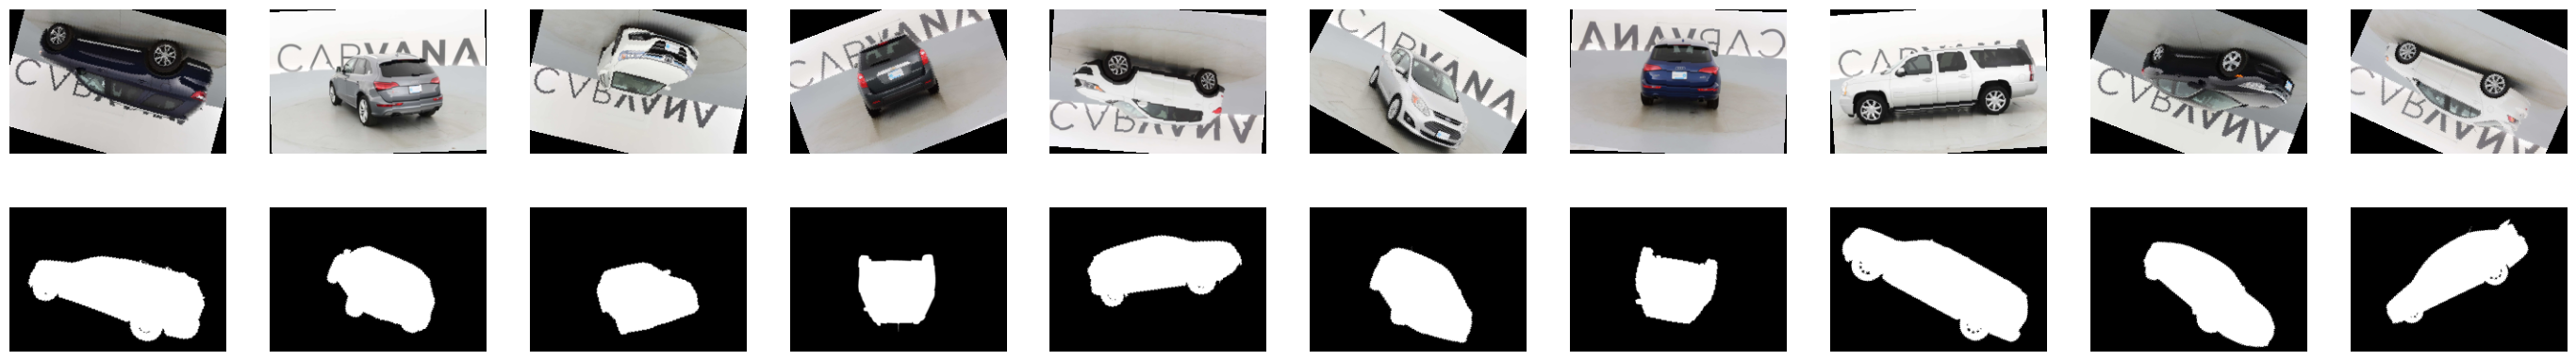

In [76]:
idx = np.random.randint(train_set.__len__(), size=10)
fig, axs = plt.subplots(2, 10, figsize=(35, 5))

for ax0, ax1, i in zip(axs[0], axs[1], idx):
    img, mask = train_set.__getitem__(i)
    ax0.imshow(img.permute(1, 2, 0))
    ax0.axis(False)

    ax1.imshow(mask.permute(1, 2, 0), cmap="gray")
    ax1.axis(False)

plt.show()

In [80]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=PIN_MEMORY)

In [78]:
train_loss = []
min_loss = float('inf')

for epoch in range(NUM_EPOCH):

    # training loop
    for image, mask in tqdm(train_loader):
        image, mask = image.to(DEVICE), mask.to(DEVICE).unsqueeze(1)

        out = model(image)
        print(out.shape)
        break

    break

  0%|          | 0/340 [00:00<?, ?it/s]

In [62]:
import shutil
images = os.listdir("../datasets/Carvana/train")
random_images = np.random.choice(images, 250)
random_masks = [x.replace(".jpg", "_mask.gif") for x in random_images]

source_img_dir = "../datasets/Carvana/train"
source_mask_dir = "../datasets/Carvana/train_masks"

dest_img_dir = "../datasets/Carvana/val"
dest_mask_dir = "../datasets/Carvana/val_masks"

for img, mask in zip(random_images, random_masks):
    source_img_path = os.path.join(source_img_dir, img)
    source_mask_path = os.path.join(source_mask_dir, mask)

    dest_img_path = os.path.join(dest_img_dir, img)
    dest_mask_path = os.path.join(dest_mask_dir, mask)

    shutil.move(src=source_img_path, dst=dest_img_path)
    shutil.move(src=source_mask_path, dst=dest_mask_path)

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/Carvana/train\\fff9b3a5373f_09.jpg'